In [51]:
# The code was removed by Watson Studio for sharing.

Project name is [{'name': 'Geospatial_Coordinates.csv', 'asset_id': 'ec985893-9010-4b9e-a9c7-c58d4bd0ac0d'}]


# The Battle of Neighborhood: Clustering Localities in Kochi City

## 1. INTRODUCTION

    Most of the people around the world loves travelling and travellers loves to explore new food varities when they visit new places. Providing highly rated restaurant with price range helps travellers to make good planning on their budget as well pick the venues based on it. By using machine learning techniques we are providing quick glance to the traveler about the venue and highly rated restaurant with affordable price range in that area. 
    Also this projects aims at business people who likes to open restaurant in a city based on the cluster of different category of restaurant and demand.
    
## 2. Data
    
     In this project we are analysing the data of Kochi city which is part of Kerala state. Our analysis is targeted at localities within 30km of Kochi city. We are making using of Foursquare APIs to get details of the venues in Kochi city and Zomato API is used for extracting the restaurant details, price range, user rating, category etc. 
    Using the name, latitude and longitude values obtained from the Foursquare API, we are using Zomato search API to fetch data from its database. The Zomato API allows to find only restaurants based on a search criteria using the name, latitude, longitude, etc.

    Various data cleaning methods are adopted here to get the final dataset.From Foursquare API , the following details of each locaities is retrieved:
* **Name:** The name of the venue 
* **Category:** The category type as defined by the Foursqaure API
* **Latitude:** The latitude value of the venue
* **Longitude:** The longitude value of the venue.

    From Zomato API, the following details of each restaurant is retrieved: 
* **Name:** The name of the restaurant
* **Locality:** The locality of the restaurant
* **Aggregate Rating:** The average rating of the restaurant given be users
* **Price range:** The price ranges of the restaurant 
* **Average cost for two:** The average cost for two people dining at the restaurant
* **Address**: Address of the resturants
* **Review count**: Total user rating count for a specific resturant
* **Latitude:** The latitude value of the restaurant
* **Longitude:** The longitude value of the restaurant
* **City:** City in which resturant belongs to 

## 3. Methodology
    
    Geolocator is used for finding the lattitude and longitude value of the Kochi city. Folium library is used for reterieving the map of Kochi City.

In [62]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [63]:
address = 'Kochi, Kerala'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  kochi City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  kochi City are 9.9340738, 76.2606304.


In [64]:
# create map of Kochi using latitude and longitude values
kochi_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [65]:
kochi_map

Define Foursquare Credentials and Version

In [66]:
CLIENT_ID = 'I32HE3AL43MTDKD4VBCKE0SZYVTA4EUR4KSHSVH30NT33KJO' # your Foursquare ID
CLIENT_SECRET = '21DSPVZQRUT5KG1MDQYUPAQ1JMGFHCJTJNITA4YD3C2EWUZD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I32HE3AL43MTDKD4VBCKE0SZYVTA4EUR4KSHSVH30NT33KJO
CLIENT_SECRET:21DSPVZQRUT5KG1MDQYUPAQ1JMGFHCJTJNITA4YD3C2EWUZD


Now, let's get the top venues  in Kochi City within a radius of 30 Kms

In [67]:
def get_foursquare_api (offset):
    LIMIT = 100
    radius = 30000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        offset)
    results = requests.get(url).json()
    return results

In [68]:
#Sample API call
results = get_foursquare_api (100)

In [69]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Foursquare API has a limit of fecthing 100 venues at a time and we are using offset for handling this

In [70]:
kochi_venues = pd.DataFrame()
offset = 0
while True:
    results = get_foursquare_api (offset)
    venue_len = len(results['response']['groups'][0]['items'])
    print("Venue length is {}".format(venue_len))
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    kochi_venues = kochi_venues.append(nearby_venues, ignore_index = True)
    if venue_len < 100:
        break
    else:
        offset = offset + 100
        

Venue length is 94


In [73]:
print('{} venues were returned by Foursquare.'.format(kochi_venues.shape[0]))

94 venues were returned by Foursquare.


In [74]:
# add markers to map
for lat, lng, label in zip(kochi_venues['lat'], kochi_venues['lng'], kochi_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(kochi_map)  
kochi_map

### Zomato API call
    Let us first define the user-key generated from the zomato developer account


In [75]:
headers = {'user-key': '36a42554f93b2bd1a4dad82816dd9981'}

In [76]:
# Sample API call
url = 'https://developers.zomato.com/api/v2.1/categories'
print(url)
zomato_results = requests.get(url, headers=headers).json()
zomato_results

https://developers.zomato.com/api/v2.1/categories


{'categories': [{'categories': {'id': 1, 'name': 'Delivery'}},
  {'categories': {'id': 2, 'name': 'Dine-out'}},
  {'categories': {'id': 3, 'name': 'Nightlife'}},
  {'categories': {'id': 4, 'name': 'Catching-up'}},
  {'categories': {'id': 5, 'name': 'Takeaway'}},
  {'categories': {'id': 6, 'name': 'Cafes'}},
  {'categories': {'id': 7, 'name': 'Daily Menus'}},
  {'categories': {'id': 8, 'name': 'Breakfast'}},
  {'categories': {'id': 9, 'name': 'Lunch'}},
  {'categories': {'id': 10, 'name': 'Dinner'}},
  {'categories': {'id': 11, 'name': 'Pubs & Bars'}},
  {'categories': {'id': 13, 'name': 'Pocket Friendly Delivery'}},
  {'categories': {'id': 14, 'name': 'Clubs & Lounges'}}]}

Using the Zomato search API for fecthing the resturants corresponding to a venue and its lattitude and longitude values


In [77]:
kochi_rest = pd.DataFrame()
for ind in kochi_venues.index: 
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=20&lat={}&lon={}&sort=real_distance').format(kochi_venues['name'][ind], kochi_venues['lat'][ind], kochi_venues['lng'][ind])
    result = requests.get(url, headers = headers).json()
    print("Zomato details of venue {}".format(kochi_venues['name'][ind]))
    nearby_rest = json_normalize(result['restaurants'])
    kochi_rest = kochi_rest.append(nearby_rest, ignore_index = True)  

Zomato details of venue Kashi Art Cafe
Zomato details of venue Cocoa Tree


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Zomato details of venue Springr
Zomato details of venue Pepper House
Zomato details of venue Tibetan Chef's Restaurant
Zomato details of venue Cocoa Tree
Zomato details of venue Grand Hyatt Hotel Bolgatty
Zomato details of venue Couchyn
Zomato details of venue Fort House
Zomato details of venue ChicKing
Zomato details of venue Shifu Momozzz
Zomato details of venue The Brunton Boatyard Hotel Kochi
Zomato details of venue Dal Roti
Zomato details of venue Oceanos Seafood
Zomato details of venue Mezzo
Zomato details of venue Fort Kochi Beach
Zomato details of venue Avenue Regent
Zomato details of venue David Hall
Zomato details of venue Milano Ice Cream
Zomato details of venue BTH Sarovaram
Zomato details of venue Ojeen
Zomato details of venue Hotel Grand
Zomato details of venue Shappu Curry
Zomato details of venue Tea Pot
Zomato details of venue Kahawa Bistro
Zomato details of venue French Toast
Zomato details of venue Rajiv Gandhi indoor stadium
Zomato details of venue Kayees Biriyani
Zo

In [78]:
#Let us save the datas to csv file as zomato REST API has daily REST call limit
kochi_rest.to_csv('/home/dsxuser/work/kochi_resturant.csv')

In [79]:
# filter columns
filtered_columns = ['restaurant.name', 'restaurant.location.latitude', 'restaurant.location.longitude', 'restaurant.location.address', 'restaurant.location.city', 'restaurant.location.locality', 'restaurant.average_cost_for_two', 'restaurant.all_reviews_count', 'restaurant.price_range', 'restaurant.user_rating.aggregate_rating']
kochi_rest =kochi_rest.loc[:, filtered_columns]

# clean columns
kochi_rest.columns = [col.split(".")[-1] for col in kochi_rest.columns]


In [80]:
kochi_rest['name'].value_counts()

Baskin Robbins                                              21
Chicking                                                    18
Subway                                                      16
Bakery B by Best Bakers                                     10
Malabar Plaza                                               10
The Pulp Factory                                             9
Domino's Pizza                                               9
Ceylon Bake House                                            9
Noodle King                                                  9
Haji Ali                                                     8
Amul Ice Cream Parlour                                       8
Gokul Oottupura                                              8
Qissa Cafe                                                   6
Cafe Coffee Day                                              6
Bristow's Bistro                                             6
Bread World                                            

## Data Cleaning

Removing the duplicate resturant name from the data frame

In [81]:
# dropping duplicate values 
kochi_rest.drop_duplicates(keep=False,inplace=True)

In [82]:
kochi_rest.dtypes

name                    object
latitude                object
longitude               object
address                 object
city                    object
locality                object
average_cost_for_two     int64
all_reviews_count        int64
price_range              int64
aggregate_rating        object
dtype: object

In [83]:
# Converting the object format of lattitude, longitude and aggregate_rating to real numbers
convert_dict = {'latitude': float, 
                'longitude': float,
                'aggregate_rating': float
               } 
kochi_filtered_venues = kochi_rest.astype(convert_dict) 

Let us remove the rows which is having review count as zero and customer review rating as zero, inorder to make our analysis easier

In [84]:
kochi_filtered_venues = kochi_filtered_venues[(kochi_filtered_venues['all_reviews_count'] > 0) & (kochi_filtered_venues['aggregate_rating'] > 0)].reset_index()


In [85]:
kochi_filtered_venues = kochi_filtered_venues.drop(['index'], axis=1)


In [86]:
kochi_filtered_venues

,name,latitude,longitude,address,city,locality,average_cost_for_two,all_reviews_count,price_range,aggregate_rating
0,Pizza Italia,9.964485,76.242884,"464 F, Tower Road, Fort Kochi, Kochi",Kochi,Fort Kochi,1000,56,3,4.2
1,Hot Breads,9.965392,76.285797,"Ambady Apartment, Warriam Road, Pallimukku, Kochi",Kochi,Pallimukku,300,22,1,3.7
2,Hot Breads,9.962728,76.295441,"GCDA Shopping Complex, Panampilly Nagar, Kochi",Kochi,Panampilly Nagar,300,17,1,3.6
3,Bread World,9.971914,76.302217,"Jawahar Nagar, Subhash Chandra Bose Road, Elam...",Kochi,Elamkulam,450,38,1,3.9
4,CK's Bakery,9.992241,76.292897,"65/850, Kaloor Kadavanthra Road, Kaloor, Kochi",Kochi,Kaloor,200,16,1,4.2
5,Sundae Sprinkle,10.033283,76.313248,"31/381 A, Nanus Complex, National Highway 47, ...",Kochi,Elamkulam,200,2,1,3.3
6,Chopstix,10.024925,76.338347,"Seaport Airport Road, Ernakulam, Kakkanad, Kochi",Kochi,Kakkanad,800,154,2,4.2
7,Grill House,9.949668,76.255748,"8/1248-1, Opposite West Panayapilly Bus Stop, ...",Kochi,Chullickal,250,2,1,3.2
8,Ceylon Bake House,9.945513,76.257625,"Door 10/467 B, Chullickal, Kochi",Kochi,Chullickal,500,12,2,3.1
9,Sutra Restaurant,9.966661,76.241795,"Hotel Rossitta Wood Castle, 1/334 Rose Street,...",Kochi,Fort Kochi,500,130,2,4.3


### Data Analysis

#### A. Number of Restaurants in each Locality

<BarContainer object of 51 artists>

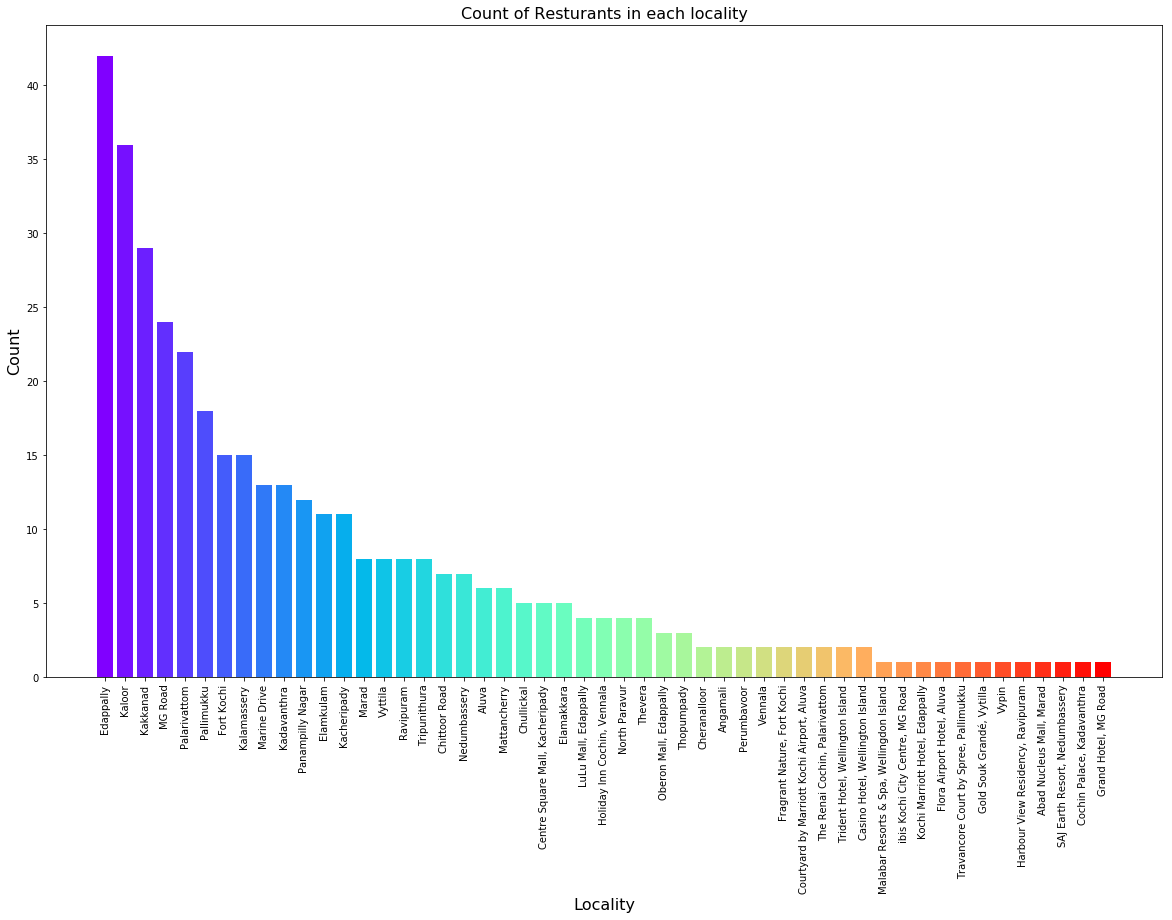

In [87]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


resturant_distribution = kochi_filtered_venues['locality'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(resturant_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Locality", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of Resturants in each locality", fontsize = 16)
plt.bar(resturant_distribution.index, resturant_distribution.values, color = colors)

#### B. Average price for two in restaurants in each locality:

In [88]:
price_for_two = kochi_filtered_venues[['locality', 'average_cost_for_two']]
cost_disctribution = price_for_two.groupby(['locality']).mean()


<BarContainer object of 51 artists>

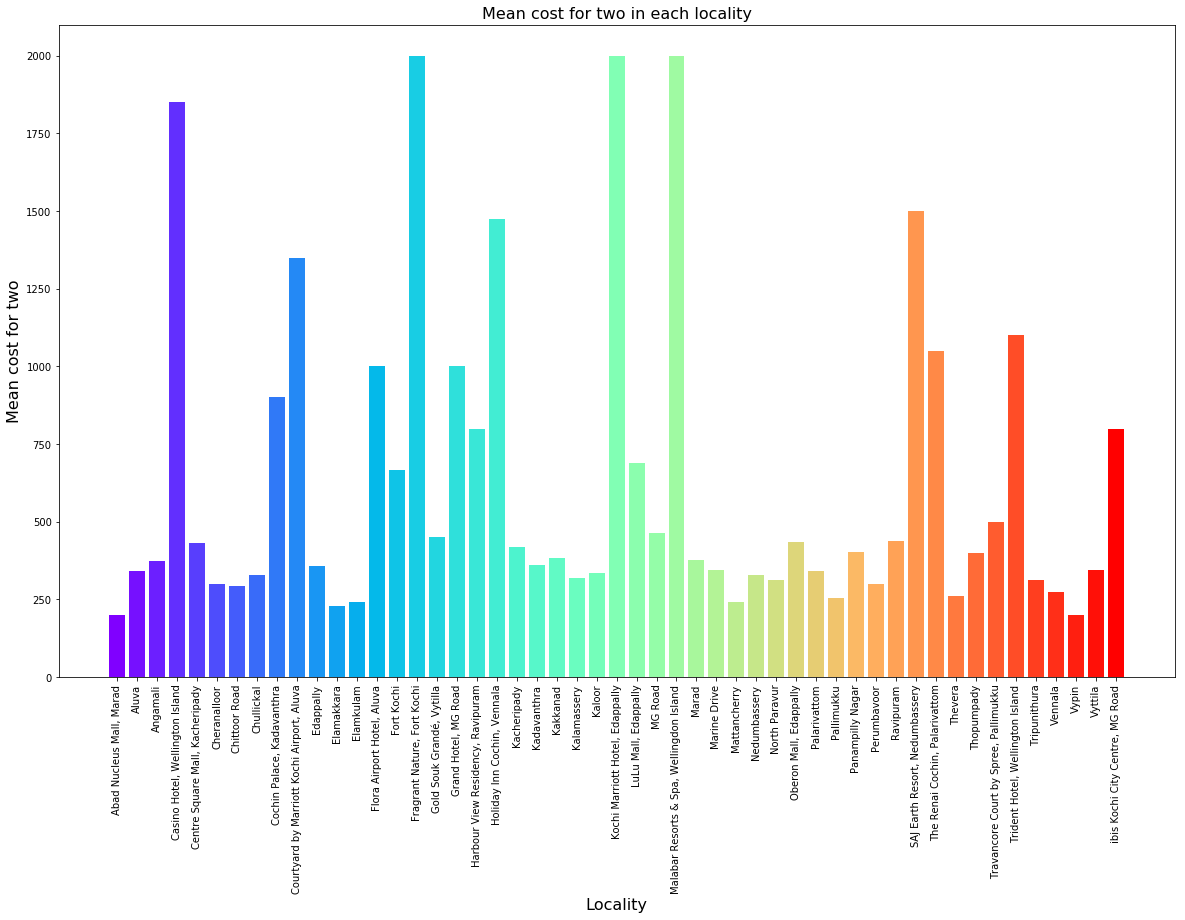

In [89]:
colors = cm.rainbow(np.linspace(0, 1, len(cost_disctribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Locality", fontsize = 16)
plt.ylabel("Mean cost for two", fontsize = 16)
plt.title("Mean cost for two in each locality", fontsize = 16)
plt.bar(cost_disctribution.index, cost_disctribution['average_cost_for_two'], color = colors)

#### C.Mean of aggregate ratings of resturants in each localities

In [90]:
agg_rating = kochi_filtered_venues[['locality', 'aggregate_rating']]
agg_distribution = agg_rating.groupby(['locality']).mean()

<BarContainer object of 51 artists>

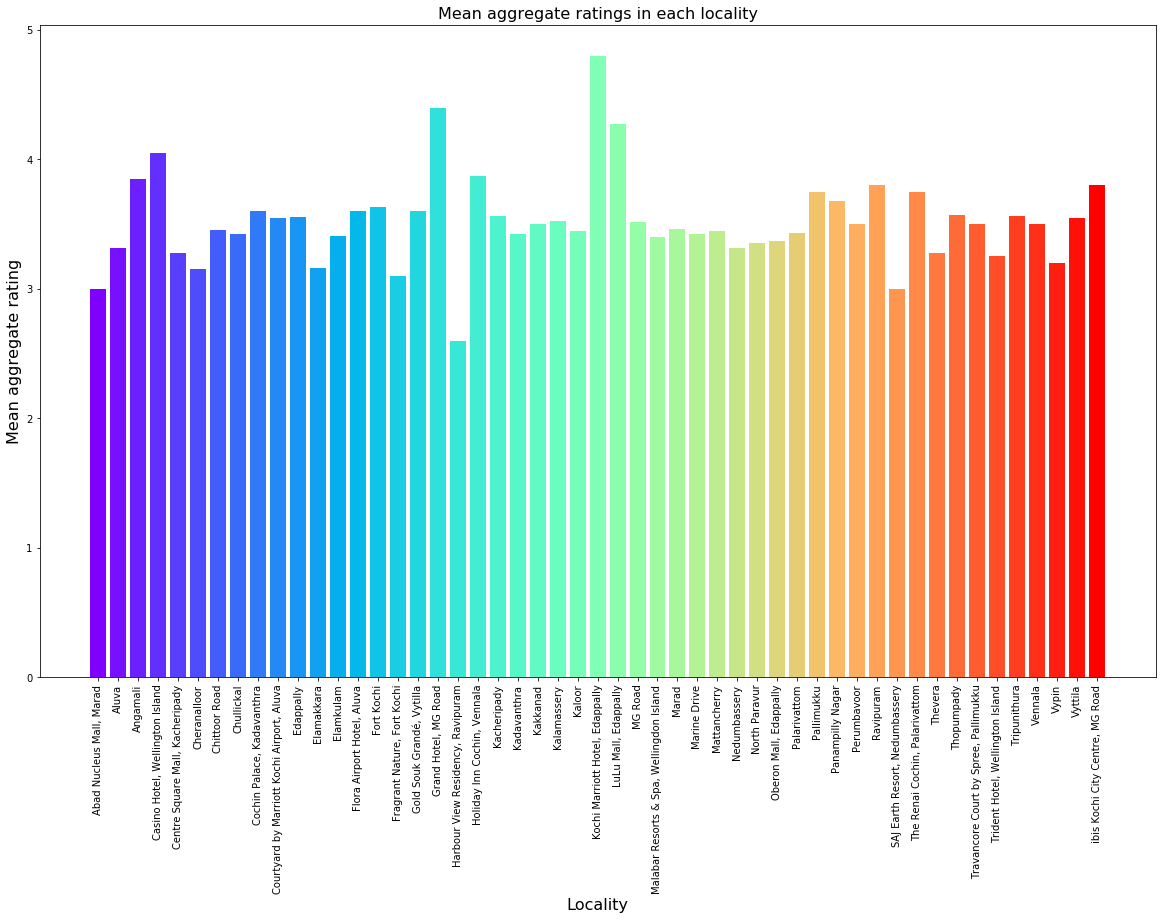

In [91]:
colors = cm.rainbow(np.linspace(0, 1, len(agg_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Locality", fontsize = 16)
plt.ylabel("Mean aggregate rating", fontsize = 16)
plt.title("Mean aggregate ratings in each locality", fontsize = 16)
plt.bar(agg_distribution.index, agg_distribution['aggregate_rating'], color = colors)

Text(0.5, 1.0, 'Count of localities')

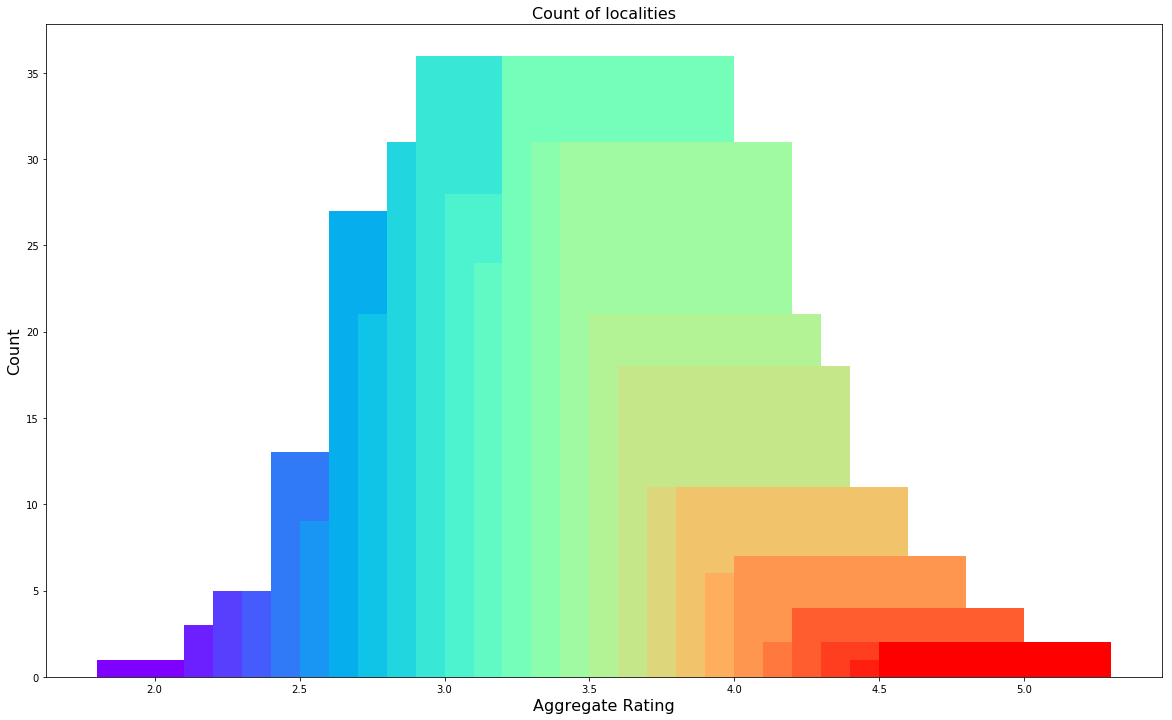

In [92]:
rest_rating = kochi_filtered_venues['aggregate_rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rest_rating.index, rest_rating.values, color = cm.rainbow(np.linspace(0, 1, len(rest_rating.index))))
plt.xlabel("Aggregate Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of localities", fontsize = 16)

The above bar diagram shows that most of localities in Kochi has **ratings of 3.5**

In [93]:
# create map of Kochi using latitude and longitude values
kochi_rest_map = folium.Map(location=[latitude, longitude], zoom_start=12)
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Very Low', 'Low', 'Good', 'Very good']
kochi_filtered_venues['rating_bin'] = pd.cut(kochi_filtered_venues['aggregate_rating'], bins = bins, labels = labels, include_lowest = True)

In [94]:
color_map = {'Very Low': 'red', 'Low': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

In [95]:
# add markers to map
for locality, address, latitude, longitude, rating_bin in zip(kochi_filtered_venues['locality'], 
                                                          kochi_filtered_venues['address'], 
                                                          kochi_filtered_venues['latitude'], 
                                                          kochi_filtered_venues['longitude'], 
                                                          kochi_filtered_venues['rating_bin']):
    label = '{}, {}'.format(locality, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(kochi_rest_map)  

kochi_rest_map.save("/home/dsxuser/work/kochi_rest_map.html")
kochi_rest_map

## Clustering

K-means clustering algorithm is used for clustering the localities based on price for two and aggregate rating

In [96]:

from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

kochi_cluster = kochi_filtered_venues.drop(['name', 'address', 'city', 'locality', 'all_reviews_count', 'price_range', 'rating_bin'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(kochi_cluster)
kochi_filtered_venues.insert(0, 'cluster_labels', kMeans.labels_)


In [105]:
kochi_cluster_map = folium.Map(location = [latitude, longitude], zoom_start = 12)
color_map = { 0: 'green', 1: 'orange', 2: 'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(kochi_filtered_venues['locality'], 
                                                        kochi_filtered_venues['address'], 
                                                        kochi_filtered_venues['cluster_labels'], 
                                                        kochi_filtered_venues['latitude'], 
                                                        kochi_filtered_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(kochi_cluster_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(kochi_cluster_map)

kochi_cluster_map.save("/home/dsxuser/work/kochi_cluster_map.html")
kochi_cluster_map

#### Cluster 1 details


In [98]:
cluster_1 = kochi_filtered_venues[kochi_filtered_venues['cluster_labels'] == 0]
print("Cluster -1 Analysis")
cluster_1.reset_index(drop = True)

Cluster -1 Analysis


,cluster_labels,name,latitude,longitude,address,city,locality,average_cost_for_two,all_reviews_count,price_range,aggregate_rating,rating_bin
0,0,Pizza Italia,9.964485,76.242884,"464 F, Tower Road, Fort Kochi, Kochi",Kochi,Fort Kochi,1000,56,3,4.2,Very good
1,0,Chopstix,10.024925,76.338347,"Seaport Airport Road, Ernakulam, Kakkanad, Kochi",Kochi,Kakkanad,800,154,2,4.2,Very good
2,0,Nasi And Mee,9.975469,76.283456,"66/6539, 2nd Floor, Narayanan Seva Sangam Buil...",Kochi,MG Road,1000,192,3,4.7,Very good
3,0,The Cochin Trader Bar - Trident Hotel,9.959678,76.269103,"Trident Hotel, Bristow Road, Willingdon Island...",Kochi,"Trident Hotel, Wellington Island",1200,2,3,3.2,Good
4,0,Pizza Hut,9.967696,76.244559,"Survey 18, Unit 1, Ground Floor, Fort Kochi, K...",Kochi,Fort Kochi,600,3,2,3.1,Good
5,0,Rasoi,9.966178,76.241552,"Near St. Francis Church, Rose Street, Fort Koc...",Kochi,Fort Kochi,1000,70,3,4.0,Good
6,0,Fusion Bay,9.965461,76.243697,"KB Jacob Road, Near Santa Cruz Basilica Church...",Kochi,Fort Kochi,600,198,2,4.5,Very good
7,0,Old Harbour Hotel,9.967196,76.242451,"1/328, Tower Road, Fort Kochi, Kochi",Kochi,Fort Kochi,800,3,2,3.4,Good
8,0,Miette,9.965048,76.241750,"Peter Celli Street, Fort Nagar, Fort Kochi, Kochi",Kochi,Fort Kochi,600,3,2,3.2,Good
9,0,Happy Cup,9.958995,76.296132,"56/2622, Main Avenue, Ernakulam, Panampilly Na...",Kochi,Panampilly Nagar,600,6,2,3.3,Good


In [99]:
print("Mean of cluster -1 for average_cost_for_two {} aggregate_rating {}".format(cluster_1['average_cost_for_two'].mean(), cluster_1['aggregate_rating'].mean()))


Mean of cluster -1 for average_cost_for_two 807.4074074074074 aggregate_rating 3.6851851851851865


In [100]:
cluster_2 = kochi_filtered_venues[kochi_filtered_venues['cluster_labels'] == 1]
print("Cluster -2 Analysis")
cluster_2.reset_index(drop = True)

Cluster -2 Analysis


,cluster_labels,name,latitude,longitude,address,city,locality,average_cost_for_two,all_reviews_count,price_range,aggregate_rating,rating_bin
0,1,Hot Breads,9.965392,76.285797,"Ambady Apartment, Warriam Road, Pallimukku, Kochi",Kochi,Pallimukku,300,22,1,3.7,Good
1,1,Hot Breads,9.962728,76.295441,"GCDA Shopping Complex, Panampilly Nagar, Kochi",Kochi,Panampilly Nagar,300,17,1,3.6,Good
2,1,Bread World,9.971914,76.302217,"Jawahar Nagar, Subhash Chandra Bose Road, Elam...",Kochi,Elamkulam,450,38,1,3.9,Good
3,1,CK's Bakery,9.992241,76.292897,"65/850, Kaloor Kadavanthra Road, Kaloor, Kochi",Kochi,Kaloor,200,16,1,4.2,Very good
4,1,Sundae Sprinkle,10.033283,76.313248,"31/381 A, Nanus Complex, National Highway 47, ...",Kochi,Elamkulam,200,2,1,3.3,Good
5,1,Grill House,9.949668,76.255748,"8/1248-1, Opposite West Panayapilly Bus Stop, ...",Kochi,Chullickal,250,2,1,3.2,Good
6,1,Ceylon Bake House,9.945513,76.257625,"Door 10/467 B, Chullickal, Kochi",Kochi,Chullickal,500,12,2,3.1,Good
7,1,Sutra Restaurant,9.966661,76.241795,"Hotel Rossitta Wood Castle, 1/334 Rose Street,...",Kochi,Fort Kochi,500,130,2,4.3,Very good
8,1,Thoni Seafood Restaurant,9.955845,76.242381,"27/1918A, K B Jacob Road, Fort Kochi, Kochi",Kochi,Fort Kochi,300,7,1,3.4,Good
9,1,Hotel Kismath,9.983310,76.273933,"Swapnil Enclave, High Court Junction, Marine D...",Kochi,Marine Drive,200,5,1,3.2,Good


In [101]:
print("Mean of cluster -2 for average_cost_for_two {} aggregate_rating {}".format(cluster_2['average_cost_for_two'].mean(), cluster_2['aggregate_rating'].mean()))

Mean of cluster -2 for average_cost_for_two 314.0372670807453 aggregate_rating 3.481987577639753


In [102]:
cluster_3 = kochi_filtered_venues[kochi_filtered_venues['cluster_labels'] == 2]
print("Cluster -3 Analysis")
cluster_3.reset_index(drop = True)
print("Mean of cluster -3 for average_cost_for_two {} aggregate_rating {}".format(cluster_3['average_cost_for_two'].mean(), cluster_3['aggregate_rating'].mean()))

Cluster -3 Analysis
Mean of cluster -3 for average_cost_for_two 1930.0 aggregate_rating 3.71


## 4. RESULTS AND DISCUSSIONS

The data analysis performed here helps visitor to take good decsision based on there budget and preferences while visiting **Kochi, Kerala**. Below are the some of the conclusion which we can derived based on above analysis.
* Resturant counts are more in area close to **Edappally** and **Kaloor**
* The most costlier resturant in Kochi are in locality **Kochi Marriott Hotel Edappally**, **Fargrant FortKochi and** **Malabar Resorts & Spa, Wellingdon Island**
* **Kaloor** locality finds to be more budget friendly, has good eateries count and has good aggregate ratings as well so good place to visit

Below are the conclusion we can derive from the K-means clustering algorithm
* Localities coming under cluster-2 is having **avg cost for two = 306 and rating = 3.48**
* Localities coming under cluster-1 is having **avg cost for two = 807 and rating = 3.68**
* Localities coming under cluster-3 is having **avg cost for two = 1930 and rating = 3.71**

Most of the localities in centre of kochi city is falling under cluster-2. Most expensive localities in Kochi has good customer ratings.

## 5. CONCLUSION

In this project we are making use of Foursquare and Zomato APIs to explore insight into the eateries in Kochi city. 
The data analysis performed here can be used by the new visitors 
who likes to visit the Kochi and plan their budget based on the data available here. 
The data can be used by the Business people who has plan to start the bussiness as it provides 
the cluster distribution of eateries and its ratings as well as price for two people. The locality **Kaloor**
finds to be budget friendly and most of the eateries avaialble in Kochi has good customer rating. So its a reasonable
choice to visit Kochi city


In [103]:
!pwd

/home/dsxuser/work
